<a href="https://colab.research.google.com/github/antragoudaras/NLP_1/blob/main/NLP1_2023_Practical_1_Tony.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="display: block; margin-left: auto; margin-right: auto; width: 200px;"/></a>

------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused.

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [1]:
!python --version

Python 3.10.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [2]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
# from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
import copy

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [3]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2023-11-14 16:32:14--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.2’

sent_lexicon.2      100%[===================>] 647.05K  --.-KB/s    in 0.03s   

2023-11-14 16:32:14 (18.4 MB/s) - ‘sent_lexicon.2’ saved [662577/662577]

--2023-11-14 16:32:14--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercont

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [4]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [5]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [6]:
def load_sent_lexicon(filename):
  lexicon = {}
  with open(filename, mode="r", encoding="utf-8") as f:
    for line in f:
      line_dict = {}
      tokens = line.strip().split()
      line_dict[tokens[-1].split('=')[0]] = tokens[-1].split('=')[1] #take 'pripolarity' token, pripolarity=['positive', 'negative' , 'neutral', 'both']
      line_dict[tokens[0].split('=')[0]] = tokens[0].split('=')[1] #take 'type' token
      lexicon[tokens[2].split('=')[1]] = line_dict
  return lexicon

def return_sign(token_lex_dict):
    """Returns the sign of the token polarity"""
    if token_lex_dict["priorpolarity"] == "positive":
        return 1
    elif token_lex_dict["priorpolarity"] == "negative":
        return -1
    else: #neutral or both
        return 0

def tokenized_results(reviews, lex_dict, threshold=8):
    """Returns the predicted class label for each review, 1 if positive, 0 if negative"""
    predictions = []
    for review in reviews:
        tokenized_results = []
        for sentence in review["content"]:
            for token, _ in sentence:
                if token.lower() in lex_dict:
                    tokenized_results.append(return_sign(lex_dict[token.lower()]))
        if np.sum(tokenized_results) > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

def return_true_labels(reviews):
  return[1 if (review["sentiment"] == 'POS') else  0 for review in reviews]

In [7]:
Lex_dict = load_sent_lexicon("sent_lexicon")
true_labels = return_true_labels(reviews)

In [8]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = tokenized_results(reviews, Lex_dict, threshold=8)
token_accuracy = sum([1 for i in range(len(token_results)) if token_results[i] == true_labels[i]]) / len(token_results)
print("Accuracy: %0.3f" % token_accuracy)

Accuracy: 0.677


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [9]:
def return_sign_magnitude(token_lex_dict, magnitude):
    """Returns the sign of the token polarity multiplied by the magnitude"""
    if token_lex_dict["priorpolarity"] == "positive":
        if token_lex_dict['type'] == "weaksubj":
            return 1
        else:
           return 1*magnitude
    elif token_lex_dict["priorpolarity"] == "negative":
        if token_lex_dict['type'] == "weaksubj":
            return -1
        else:
           return -1*magnitude
    else: #neutral or both
        return 0

def tokenized_results_magnitude(reviews, lex_dict, threshold=8, magnitude=1.5):
    """Returns the predicted class label for each review, 1 if positive, 0 if negative"""
    predictions = []
    for review in reviews:
        tokenized_results = []
        for sentence in review["content"]:
            for token, _ in sentence:
                if token.lower() in lex_dict:
                    tokenized_results.append(return_sign_magnitude(lex_dict[token.lower()], magnitude))

        if sum(tokenized_results) > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

In [10]:
token_results = tokenized_results_magnitude(reviews, Lex_dict, threshold=16, magnitude=2)
magnitude_accuracy = sum([1 for i in range(len(token_results)) if token_results[i] == true_labels[i]]) / len(token_results)
print("Accuracy: %0.3f" % magnitude_accuracy)

Accuracy: 0.687


#### (Q.1.3) Make a barplot of the two results (0.5pt)

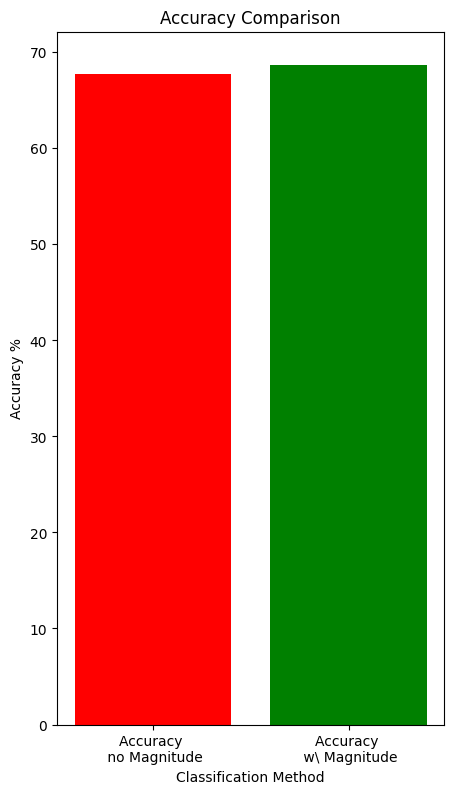

In [11]:
# Plotting the accuracies in a bar plot
fig = plt.figure(figsize=(5, 9))
accuracies = [100*token_accuracy, 100*magnitude_accuracy]
labels = ['Accuracy \n no Magnitude', 'Accuracy \n w\ Magnitude']
colors = ['red', 'green'] # add colors for each element in accuracies
plt.bar(labels, accuracies, color=colors) # use the colors parameter to set the colors
plt.title('Accuracy Comparison')
plt.xlabel('Classification Method')
plt.ylabel('Accuracy %')
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

**Answer Q1.4**:

The problem is that since we have used a fixed threshold (that captures the bias in the dataset), reviews of larger or smaller sizes than the average could be classified incorrectly. For example, the threshold must be adequately downscaled for a positive review with fewer words than the average to be classified correctly. Similarly, we need to adjust the threshold for reviews with more words than the average.

In order to resolve this problem, we have created two methods, both taking into account the document length (size of the review).
Instead of considering the dataset's bias, the first approach compares the average ratio of the weighted binary score with respect to words per review of all reviews to the ratio of the weighted binary score to words per review for the review in test time.

The second approach calculates a normalized threshold per review in test time by multiplying the original threshold with the ratio of words in the tested review to the average words per review (calculated by taking into account all reviews): $\newline$
$$\frac{words\_in\_a\_review\_under\_test}{average\_words\_per\_review}$$

Then, the weighted binary score of each review is compared to the following normalized threshold: $$orig\_thes. \times \frac{words\_in\_a\_review\_under\_test}{average\_words\_per\_review}$$ and a classification decision is made.

In [12]:
def calc_avg_score(reviews, lex_dict, magnitude):
    """Returns the dynamic threshold for a given set of reviews - Method 1"""
    scores = []
    for review in reviews:
        tokenized_results = []
        words_per_review = 0
        for sentence in review["content"]:
            for token, _ in sentence:
                words_per_review += 1
                if token.lower() in lex_dict:
                    tokenized_results.append(return_sign_magnitude(lex_dict[token.lower()], magnitude))
        scores.append(sum(tokenized_results)/words_per_review) # calculate the average score for each review
    return np.mean(scores) # return the average score for all reviews


def tokenized_dynamic_threshold(reviews, lex_dict, magnitude=1.5):
    """Returns the predicted class label for each review, 1 if positive, 0 if negative with dynamic threshold - Method 1 without the use of original threshold"""
    avg_score = calc_avg_score(reviews, lex_dict, magnitude)
    predictions = []
    for review in reviews:
        tokenized_results = []
        words_per_review = 0
        for sentence in review["content"]:
            for token, _ in sentence:
                words_per_review += 1
                if token.lower() in lex_dict:
                    tokenized_results.append(return_sign_magnitude(lex_dict[token.lower()], magnitude))

        if sum(tokenized_results) / words_per_review > avg_score:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

In [13]:
adjusted_token_results = tokenized_dynamic_threshold(reviews, Lex_dict, magnitude=2)
dynamic_accuracy = sum([1 for i in range(len(adjusted_token_results)) if adjusted_token_results[i] == true_labels[i]]) / len(adjusted_token_results)
print(f"Accuracy: {100*dynamic_accuracy}%")

Accuracy: 69.15%


In [14]:
def calc_avg_words_per_review(reviews):
    """Returns the average number of words per review"""
    total_words = sum(len(sentence) for review in reviews for sentence in review["content"])
    avg_words_per_review = int(total_words / len(reviews))
    return avg_words_per_review

def tokenized_dynamic_threshold_w_org_thres(reviews, lex_dict, original_threshold=8, magnitude=1.5):
    """Returns the predicted class label for each review, 1 if positive, 0 if negative with dynamic threshold - Method 2 with the use of original threshold"""
    avg_words_per_review = calc_avg_words_per_review(reviews)
    predictions = []
    for review in reviews:
        tokenized_results = []
        words_per_review = 0
        for sentence in review["content"]:
            for token, _ in sentence:
                words_per_review += 1
                if token.lower() in lex_dict:
                    tokenized_results.append(return_sign_magnitude(lex_dict[token.lower()], magnitude))

        normalized_threshold = original_threshold * (words_per_review / avg_words_per_review)
        if sum(tokenized_results) > normalized_threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

In [15]:
dynamic_token_results = tokenized_dynamic_threshold_w_org_thres(reviews, Lex_dict, original_threshold=16, magnitude=2)
dynamic_accuracy = sum([1 for i in range(len(dynamic_token_results)) if dynamic_token_results[i] == true_labels[i]]) / len(dynamic_token_results)
print(f"Accuracy: {100*dynamic_accuracy}%")

Accuracy: 69.19999999999999%


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

**Answer Q2.1**: TODO

In [16]:
def get_train_test_set(reviews, train_size_per_sentiment=900):
    """Returns the train and test set of the reviews with the specified train and test size"""
    train_set = [review for review in reviews if review["cv"] < train_size_per_sentiment]
    test_set = [review for review in reviews if review["cv"] >=train_size_per_sentiment]
    return train_set, test_set

def get_unique_per_class_tokens(reviews_train_set):
    """Returns a set of unique tokens that make of vocab, for negative and positive reviews separately"""
    negative_vocab = set(token.lower() for review in reviews_train_set if review['sentiment'] == 'NEG' for sentence in review["content"] for token, _ in sentence)
    positive_vocab = set(token.lower() for review in reviews_train_set if review['sentiment'] == 'POS' for sentence in review["content"] for token, _ in sentence)
    return negative_vocab, positive_vocab


def ignore_unseen_words(reviews_train_set, reviews_test_set):
    """Returns the modified test set where unseen words in training that have been removed"""
    unique_negative_tokens, unique_positive_tokens = get_unique_per_class_tokens(reviews_train_set)
    processed_test_set = copy.deepcopy(reviews_test_set)
    for review in processed_test_set:
        for sentence in review["content"]:
            i = 0
            while i < len(sentence):
                token, _ = sentence[i]
                if (token.lower() in unique_negative_tokens) and (token.lower() in unique_positive_tokens): #seen in both classes
                    i += 1
                else: #remove the token from the sentence, case 1 not seen in both classes, case 2 not seen in either positive or negative class
                    sentence.pop(i)
    return processed_test_set

def ignore_unseen_words_second(reviews_train_set, reviews_test_set):
    """Returns the modified test set where unseen words in training that have been removed"""
    unique_negative_tokens, unique_positive_tokens = get_unique_per_class_tokens(reviews_train_set)
    processed_test_set = copy.deepcopy(reviews_test_set)
    processed_train_set = copy.deepcopy(reviews_train_set)
    for review in processed_test_set:
        for sentence in review["content"]:
            i = 0
            while i < len(sentence):
                token, _ = sentence[i]
                if (token.lower() not in unique_negative_tokens) and (token.lower() not in unique_positive_tokens): #seen in both classes
                    sentence.pop(i)
                else: #remove the token from the sentence, case 1 not seen in both classes, case 2 not seen in either positive or negative class
                    i += 1
    for review in processed_train_set:
        if review['sentiment'] == 'NEG':
            for sentence in review["content"]:
                i = 0
                while i < len(sentence):
                    token, _ = sentence[i]
                    if (token.lower() not in unique_positive_tokens):
                        sentence.pop(i)
                    else:
                        i += 1
    for review in processed_train_set:
        if review['sentiment'] == 'POS':
            for sentence in review["content"]:
                i = 0
                while i < len(sentence):
                    token, _ = sentence[i]
                    if (token.lower() not in unique_negative_tokens):
                        sentence.pop(i)
                    else:
                        i += 1

    return processed_train_set, processed_test_set

def vocab_size(input_set):
    """Returns the size of the vocabulary of the input set"""
    return len(set(token.lower() for review in input_set for sentence in review["content"] for token, _ in sentence))

In [17]:
reviews_train_set, reviews_test_set = get_train_test_set(reviews, train_size_per_sentiment=900)
processed_train_set, processed_test_set = ignore_unseen_words_second(reviews_train_set, reviews_test_set)
print('Vocab size of test_set before removing unseen words:', vocab_size(reviews_test_set))
print('Vocab size of test_set after removing unseen words:', vocab_size(processed_test_set))

Vocab size of test_set before removing unseen words: 14812
Vocab size of test_set after removing unseen words: 12417


#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [18]:
def get_vocab(input_set):
    """Returns a set of unique tokens from all the sentences of the input set"""
    return set(token.lower() for review in input_set for sentence in review["content"] for token, _ in sentence if len(token.split()) == 1)
def get_full_vocab(input_set):
    """Returns a set of unique tokens from all the sentences of the input set"""
    return set(token.lower() for review in input_set for sentence in review["content"] for token, _ in sentence)
def count_total_docs(input_set):
    """Returns the total number of documents/reviews in the input set"""
    return sum(1 for review in input_set)

def count_docs_in_class(input_set, class_label):
    """Returns the total number of documents/sentences in the input set belonging to a class"""
    return sum(1 for review in input_set if review["sentiment"] == class_label)

def concat_text_of_docs_in_class(input_set, class_label):
    """Returns a list of words/tokens of the concatenated sentences of all reviews for a specific class_label"""
    return [token.lower() for review in input_set if review["sentiment"] == class_label for sentence in review["content"] for token, _ in sentence]

In [19]:
print("Total number of Reviews/Docs in train set(both in positive and negative class):", count_total_docs(reviews_train_set))
print('Num. of reviews/#Docs in positive class:', count_docs_in_class(reviews_train_set, class_label="POS"))
print('Num. of reviews/#Docs in negative class:', count_docs_in_class(reviews_train_set, class_label="NEG"))

Total number of Reviews/Docs in train set(both in positive and negative class): 1800
Num. of reviews/#Docs in positive class: 900
Num. of reviews/#Docs in negative class: 900


In [20]:
def train_NB(reviews_train_set, k_smoothing, class_labels = ["POS", "NEG"]):
    """Trains NB without smoothing, Returns the vocabulary, prior probability of each class and conditional probability of each word given a class"""
    vocabulary = get_vocab(reviews_train_set) #extract vocabulary
    total_docs = count_total_docs(reviews_train_set) #count total number of documents
    class_prior_prob = {}
    class_cond_prob = {}
    actual_vocab = {class_label: set() for class_label in class_labels}
    for class_label in class_labels: #iterate through each class
        docs_in_class = count_docs_in_class(reviews_train_set, class_label)
        class_prior_prob[class_label] =  docs_in_class / total_docs #calculate prior probability of a class
        text_class = concat_text_of_docs_in_class(reviews_train_set, class_label) #
        word_freq = Counter(text_class) #count the frequency of each word in the text of a class
        class_cond_prob[class_label] = {}
        sum_of_words_freq = sum(word_freq.values()) #sum of frequency of all words in the vocabulary
        if k_smoothing is not None:
            for token, freq in word_freq.items():
                actual_vocab[class_label].add(token)
                if len(token.split()) > 1:
                    sub_t = ' '.join(token.split()[:-1])
                    sub_freq = word_freq[sub_t]
                    class_cond_prob[class_label][token] = (freq + k_smoothing) / (sub_freq + k_smoothing*len(vocabulary))
                else:
                    class_cond_prob[class_label][token] = (freq + k_smoothing) / (sum_of_words_freq + k_smoothing*len(vocabulary))
        else:
            for token, freq in word_freq.items(): #iterate through each word in the vocabulary
                if freq != 0: #if token is present in the text of a class, only then add it to our probab calculations
                    actual_vocab[class_label].add(token)
                    class_cond_prob[class_label][token] = freq / sum_of_words_freq #calculate conditional probability of a word given a class
    return actual_vocab, class_prior_prob, class_cond_prob


def train_NB_second(reviews_train_set, k_smoothing, class_labels = ["POS", "NEG"]):
    """Trains NB without smoothing, Returns the vocabulary, prior probability of each class and conditional probability of each word given a class"""
    vocabulary = get_vocab(reviews_train_set) #extract vocabulary
    original_vocab = get_full_vocab(reviews_train_set)
    total_docs = count_total_docs(reviews_train_set) #count total number of documents
    class_prior_prob = {}
    class_cond_prob = {}
    total_freq_per_class = {}
    actual_vocab = {class_label: set() for class_label in class_labels}
    for class_label in class_labels: #iterate through each class
        docs_in_class = count_docs_in_class(reviews_train_set, class_label)
        class_prior_prob[class_label] =  docs_in_class / total_docs #calculate prior probability of a class
        text_class = concat_text_of_docs_in_class(reviews_train_set, class_label) #
        word_freq = Counter(text_class) #count the frequency of each word in the text of a class
        class_cond_prob[class_label] = {}
        sum_of_words_freq = sum(word_freq.values()) #sum of frequency of all words in the vocabulary
        total_freq_per_class[class_label] = sum_of_words_freq

        for token, freq in word_freq.items():

            if k_smoothing is None:
                if freq != 0: #if token is present in the text of a class, only then add it to our probab calculations
                    actual_vocab[class_label].add(token)
                    class_cond_prob[class_label][token] = freq / sum_of_words_freq #calculate conditional probability of a word given a class
            else:
                actual_vocab[class_label].add(token)
                if len(token.split()) > 1:
                    sub_t = ' '.join(token.split()[:-1])
                    sub_freq = word_freq[sub_t]
                    class_cond_prob[class_label][token] = (freq + k_smoothing) / (sub_freq + k_smoothing*len(vocabulary))
                else:
                    class_cond_prob[class_label][token] = (freq + k_smoothing) / (sum_of_words_freq + k_smoothing*len(vocabulary))
    return actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, len(original_vocab)

In [21]:
def extract_unique_tokens_from_review(review):
    """Returns a set of unique tokens from all the sentences of a single review"""
    return set(token.lower() for sentence in review["content"] for token, _ in sentence)
def extract_tokens_from_review(review):
    """Returns a set of unique tokens from all the sentences of a single review"""
    return [token.lower() for sentence in review["content"] for token, _ in sentence]

def NB_per_review(review, actual_vocab, class_prior_prob, class_cond_prob, unique_tokens, k_smoothing, class_labels = ["POS", "NEG"]):
    """Returns the predicted class label for a single review 1 if positive, 0 if negative"""
    score_per_class_label = {}
    if unique_tokens == True:
        W = extract_unique_tokens_from_review(review)
    else:
        W = extract_tokens_from_review(review)

    for class_label in class_labels:
        score_per_class_label[class_label] = math.log(class_prior_prob[class_label])
        if k_smoothing is None:
            for t in W:
                if t in actual_vocab[class_label]: #only needed if we did not use smoothing
                    score_per_class_label[class_label] += math.log(class_cond_prob[class_label][t])
        else:
            for t in W:
                    score_per_class_label[class_label] += math.log(class_cond_prob[class_label][t])
    prediction = max(score_per_class_label, key=score_per_class_label.get) #return the class 'str' label with the highest score
    return 1 if prediction == "POS" else 0

def NB_per_review_second(review, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens, k_smoothing, remove_words=True, class_labels = ["POS", "NEG"]):
    """Returns the predicted class label for a single review 1 if positive, 0 if negative"""
    score_per_class_label = {}
    if unique_tokens == True:
        W = extract_unique_tokens_from_review(review)
    else:
        W = extract_tokens_from_review(review)

    for class_label in class_labels:
        score_per_class_label[class_label] = math.log(class_prior_prob[class_label])

        for t in W:
            if k_smoothing is not None:
                if t in actual_vocab[class_label]:
                    score_per_class_label[class_label] += math.log(class_cond_prob[class_label][t])
                else:
                    if remove_words == False or len(t.split()) > 1:
                        score_per_class_label[class_label] += math.log(k_smoothing / (total_freq_per_class[class_label] + (k_smoothing * vocab_len)))
            else:
                if t in actual_vocab[class_label]:
                    score_per_class_label[class_label] += math.log(class_cond_prob[class_label][t])

    prediction = max(score_per_class_label, key=score_per_class_label.get) #return the class 'str' label with the highest score
    return 1 if prediction == "POS" else 0

def test_NB(test_set, actual_vocab, class_prior_prob, class_cond_prob, unique_tokens, k_smoothing):
    """Returns a list of predicted class labels for the test set, 1 if the review was positive, 0 if negative"""
    predictions = []
    for review in test_set:
        predictions.append(NB_per_review(review, actual_vocab, class_prior_prob, class_cond_prob, unique_tokens, k_smoothing=k_smoothing))
    return predictions

def test_NB_second(test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens, k_smoothing, remove_words=True):
    """Returns a list of predicted class labels for the test set, 1 if the review was positive, 0 if negative"""
    predictions = []
    for review in test_set:
        predictions.append(NB_per_review_second(review, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens, k_smoothing=k_smoothing, remove_words=remove_words))
    return predictions

def calculate_accuracy(predictions, true_labels):
    return sum([1 for i in range(len(predictions)) if predictions[i] == true_labels[i]]) / len(predictions)

In [22]:
print("Training NB with smoothing on balanced dataset ...... without removing unseen words")
actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len = train_NB_second(reviews_train_set, k_smoothing=None)

print("Testing NB with smoothing ...... without removing unseen words")
test_predictions = test_NB_second(reviews_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=True, k_smoothing=None, remove_words=False)
test_true_labels = return_true_labels(reviews_test_set)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification accuracy: {100*accuracy}% with unique tokens")

test_predictions = test_NB_second(reviews_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=False, k_smoothing=None, remove_words=False)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification accuracy: {100*accuracy}% without unique tokens")

Training NB with smoothing on balanced dataset ...... without removing unseen words
Testing NB with smoothing ...... without removing unseen words
NB classification accuracy: 46.0% with unique tokens
NB classification accuracy: 49.5% without unique tokens


In [23]:
print("Training NB without smoothing on balanced dataset ...... after removing unseen words")
actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len = train_NB_second(processed_train_set, k_smoothing=None)

print("Testing NB without smoothing ...... after removing unseen words")
test_predictions = test_NB_second(processed_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=True, k_smoothing=None)
test_true_labels = return_true_labels(processed_test_set)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification Accuracy: {100*accuracy}% without smoothing using unique tokens")

test_predictions = test_NB_second(processed_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=False, k_smoothing=None)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification Accuracy: {100*accuracy}% without smoothing, without using unique tokens")

Training NB without smoothing on balanced dataset ...... after removing unseen words
Testing NB without smoothing ...... after removing unseen words
NB classification Accuracy: 87.5% without smoothing using unique tokens
NB classification Accuracy: 83.5% without smoothing, without using unique tokens


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

**Answer Q2.3**:

Using the unbalanced dataset ($90\%$ of the reviews in the training set are positive, $10\%$ are negative), our classifier almost overfits the majority class (positive) during test time. The fact that the classification accuracy is high ($\approx 90\%$) does not translate to the classifier capturing the actual pattern in the test set. That is because there are only 100 negative reviews and 100 positive ones in our test set. In most test cases, our classifier predicts the positive class (a positive review). Because of the unbalanced dataset, it acquires a high accuracy. In such cases, we are usually interested in other classification metrics, considering TP, FP, TN, FN, when calculating the accuracy metric. In this case, Specificity ($\frac{TN}{TN+FP}$) could be an excellent metric to capture the performance of our classifier for capturing the accuracy in the negative test cases in this unbalanced scenario. Based on the following source: (https://miro.medium.com/v2/0*-oGC3SE8sPCPdmxs.jpg)

In [24]:
def get_unbalanced_set(reviews, negative_sentiment_train_size=90, positive_sentiment_train_size=900):
    """Returns the train and test set of the reviews with the specified train and test size"""
    train_set, test_set = [], []
    for review in reviews: #iterate through the first 90 negative reviews
        if review["sentiment"] == 'NEG':
            if review["cv"] < negative_sentiment_train_size:
                train_set.append(review)
            elif review["cv"] >= (10*negative_sentiment_train_size) and review["cv"] < (10*negative_sentiment_train_size + 10):
                test_set.append(review)

    for review in reviews: #iterate through the first 1000 positive reviews
        if review["sentiment"] == 'POS':
            if review["cv"] < positive_sentiment_train_size:
                train_set.append(review)
            else:
                test_set.append(review)
    return train_set, test_set

In [25]:
unbalanced_reviews_train_set, unbalanced_reviews_test_set = get_unbalanced_set(reviews, negative_sentiment_train_size=90, positive_sentiment_train_size=900)

unbalanced_processed_train_set, unbalanced_processed_test_set = ignore_unseen_words_second(unbalanced_reviews_train_set, unbalanced_reviews_test_set)
print('Vocab size of test_set before removing unseen words:', vocab_size(unbalanced_reviews_test_set))
print('Vocab size of test_set after removing unseen words:', vocab_size(unbalanced_processed_test_set))

print("Training NB on the unbalanced dataset without smoothing ......")
actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len = train_NB_second(unbalanced_processed_train_set, k_smoothing=None)


print("Testing NB on the unbalanced dataset without smoothing ......")
test_predictions = test_NB_second(unbalanced_processed_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=True, k_smoothing=None)
test_true_labels = return_true_labels(unbalanced_processed_test_set)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification Accuracy: {100*accuracy}% on the unbalanced dataset with unique tokens")

test_predictions = test_NB_second(unbalanced_processed_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=False, k_smoothing=None)
test_true_labels = return_true_labels(unbalanced_processed_test_set)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification Accuracy: {100*accuracy}% on the unbalanced dataset without unique tokens")

Vocab size of test_set before removing unseen words: 10639
Vocab size of test_set after removing unseen words: 8797
Training NB on the unbalanced dataset without smoothing ......
Testing NB on the unbalanced dataset without smoothing ......
NB classification Accuracy: 91.81818181818183% on the unbalanced dataset with unique tokens
NB classification Accuracy: 89.0909090909091% on the unbalanced dataset without unique tokens


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [26]:
reviews_train_set, reviews_test_set = get_train_test_set(reviews, train_size_per_sentiment=900)

print("Training NB with smoothing on balanced dataset...... without removing unseen words")
actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len = train_NB_second(reviews_train_set, k_smoothing=1)

print("Testing NB with smoothing ...... without removing unseen words")
test_predictions = test_NB_second(reviews_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=True, k_smoothing=1, remove_words=False)
test_true_labels = return_true_labels(reviews_test_set)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification accuracy: {100*accuracy}% with unique tokens")

test_predictions = test_NB_second(reviews_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=False, k_smoothing=1, remove_words=False)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification accuracy: {100*accuracy}% without unique tokens")

Training NB with smoothing on balanced dataset...... without removing unseen words
Testing NB with smoothing ...... without removing unseen words
NB classification accuracy: 85.5% with unique tokens
NB classification accuracy: 82.5% without unique tokens


In [27]:
reviews_train_set, reviews_test_set = get_train_test_set(reviews, train_size_per_sentiment=900)
processed_train_set, processed_test_set = ignore_unseen_words_second(reviews_train_set, reviews_test_set)
print('Vocab size of test_set before removing unseen words:', vocab_size(reviews_test_set))
print('Vocab size of test_set after removing unseen words:', vocab_size(processed_test_set))


print("Training NB with smoothing on balanced dataset......")
actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len = train_NB_second(processed_train_set, k_smoothing=1)

print("Testing NB with smoothing ......")
test_predictions = test_NB_second(processed_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=True, k_smoothing=1)
test_true_labels = return_true_labels(processed_test_set)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification accuracy: {100*accuracy}% with unique tokens")

test_predictions = test_NB_second(processed_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=False, k_smoothing=1)
accuracy = calculate_accuracy(test_predictions, test_true_labels)
print(f"NB classification accuracy: {100*accuracy}% without unique tokens")

Vocab size of test_set before removing unseen words: 14812
Vocab size of test_set after removing unseen words: 12417
Training NB with smoothing on balanced dataset......
Testing NB with smoothing ......
NB classification accuracy: 86.5% with unique tokens
NB classification accuracy: 83.5% without unique tokens


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [28]:
def k_fold_round_robin_split(reviews, k=10):
    """Splits the reviews into k splits using a round-robin algorithm"""
    splits = [[] for _ in range(k)]
    for i, review in enumerate(reviews):
        splits[i % k].append(review)
    for i in range(k):
        test_set = splits[i]
        train_set = []
        for j in range(k):
            if j != i:
                train_set += splits[j]
        yield train_set, test_set

def k_fold_cross_validation(reviews, k):
    """Trains the NB classifier using k-fold cross-validation, instead of held out apporach
    Returns the accuracy per fold for k-fold cross validation"""
    accuracy_per_fold_unique, accuracy_per_fold = [], []
    gen = k_fold_round_robin_split(reviews, k=k)
    print("Starting k-fold cross validation ......")
    for fold in range(k):
        print("-------------------------------------------------------")
        train_set, test_set = next(gen)
        processed_train_set, processed_test_set = ignore_unseen_words_second(train_set, test_set)

        actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len = train_NB_second(processed_train_set, k_smoothing=1)

        test_predictions = test_NB_second(processed_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=True, k_smoothing=1)
        test_true_labels = return_true_labels(processed_test_set)
        accuracy = calculate_accuracy(test_predictions, test_true_labels)
        accuracy_per_fold_unique.append(accuracy)
        print(f"NB classification accuracy: {100*accuracy}% in fold {fold+1} using unique tokens")

        test_predictions = test_NB_second(processed_test_set, actual_vocab, class_prior_prob, class_cond_prob, total_freq_per_class, vocab_len, unique_tokens=False, k_smoothing=1)
        accuracy = calculate_accuracy(test_predictions, test_true_labels)
        accuracy_per_fold.append(accuracy)
        print(f"NB classification accuracy: {100*accuracy}% in fold {fold+1} without using unique tokens")
        print("-------------------------------------------------------")
    print(f'Recap: Accuracy per fold: {100*accuracy_per_fold_unique} using unique tokens')
    print(f'Recap: Accuracy per fold: {100*accuracy_per_fold} without using unique tokens')
    print(f"Average accuracy over {k} folds: {np.mean(100*accuracy_per_fold_unique)}% using unique tokens")
    print(f"Average accuracy over {k} folds: {np.mean(100*accuracy_per_fold)}% without using unique tokens")
    return accuracy_per_fold_unique, accuracy_per_fold

In [29]:
print('------------------------------------------------')
print('Vanilla NB with k-fold cross validation')
accuracy_per_fold_unique, accuracy_per_fold = k_fold_cross_validation(reviews, k=10)
print('------------------------------------------------')

------------------------------------------------
Vanilla NB with k-fold cross validation
Starting k-fold cross validation ......
-------------------------------------------------------
NB classification accuracy: 80.0% in fold 1 using unique tokens
NB classification accuracy: 78.5% in fold 1 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 86.5% in fold 2 using unique tokens
NB classification accuracy: 85.0% in fold 2 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 80.0% in fold 3 using unique tokens
NB classification accuracy: 81.0% in fold 3 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 87.5% in fold 4 using unique tokens
NB clas

In [30]:
print(f"Printing the list with accuracies: {accuracy_per_fold_unique} with unique tokens")
print(f"Printing the list with accuracies: {accuracy_per_fold} without unique tokens")

Printing the list with accuracies: [0.8, 0.865, 0.8, 0.875, 0.785, 0.86, 0.805, 0.805, 0.84, 0.8] with unique tokens
Printing the list with accuracies: [0.785, 0.85, 0.81, 0.875, 0.81, 0.865, 0.825, 0.785, 0.825, 0.825] without unique tokens


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [31]:
def compute_variance(accuracy_per_fold):
    mean = sum(accuracy_per_fold) / len(accuracy_per_fold)
    variance = sum((x - mean) ** 2 for x in accuracy_per_fold) / len(accuracy_per_fold)
    return variance

variance_unique = compute_variance(accuracy_per_fold_unique)
variance = compute_variance(accuracy_per_fold)
print(f"Variance of the 10 accuracy scores: {variance_unique} using unique tokens")
print(f"Variance of the 10 accuracy scores: {variance} without using unique tokens")

print('Using numpy for cross-validation')
print(f'Numpy Variance of the 10 accuracy scores: {np.var(accuracy_per_fold_unique)} using unique tokens')
print(f'Numpy Variance of the 10 accuracy scores: {np.var(accuracy_per_fold)} without using unique tokens')

Variance of the 10 accuracy scores: 0.0009802499999999985 using unique tokens
Variance of the 10 accuracy scores: 0.0008372499999999991 without using unique tokens
Using numpy for cross-validation
Numpy Variance of the 10 accuracy scores: 0.0009802499999999985 using unique tokens
Numpy Variance of the 10 accuracy scores: 0.0008372499999999991 without using unique tokens


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [32]:
def apply_stemming(reviews):
    """Returns the reviews with the tokens stemmed"""
    stemmer = PorterStemmer()
    stemmed_reviews = copy.deepcopy(reviews)
    for review in stemmed_reviews:
        for sentence in review["content"]:
            for i, (token, pos_tag) in enumerate(sentence):
                sentence[i] = (stemmer.stem(token, to_lowercase=True), pos_tag)
    return stemmed_reviews

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


**Answer Q2.7**:

Using the stemming method did not have a significant impact on the acquired classification accuracy of the classifier. The average accuracy of stemming with NB on the cross-fold validation was $\approx 0.8\%$ lower than the vanilla NB classifier.

**(Maybe include why this is the case)**.

In [33]:
print('------------------------------------------------')
print('NB with stemming with k-fold cross validation')
stemmed_reviews = apply_stemming(reviews)
stemmed_accuracy_per_fold_unique, stemmed_accuracy_per_fold = k_fold_cross_validation(stemmed_reviews, k=10)
print('------------------------------------------------')

------------------------------------------------
NB with stemming with k-fold cross validation
Starting k-fold cross validation ......
-------------------------------------------------------
NB classification accuracy: 81.0% in fold 1 using unique tokens
NB classification accuracy: 77.0% in fold 1 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 84.0% in fold 2 using unique tokens
NB classification accuracy: 83.5% in fold 2 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 79.0% in fold 3 using unique tokens
NB classification accuracy: 80.5% in fold 3 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 88.0% in fold 4 using unique tokens
N

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [34]:
def count_features(input_set):
    """Returns a set of unique tokens from all the sentences of the input set"""
    return len(set(token.lower() for review in input_set for sentence in review["content"] for token, _ in sentence))

In [35]:
print(f"Num. of features in NB without using stemming: {count_features(reviews_train_set)}, before removing case2 unseen words")


print(f"Num. of features in NB without using stemming: {count_features(processed_train_set)}, after removing case2 unseen words")
print('------------------------------------------------')
stemmed_train_set, stemmed_test_set = get_train_test_set(stemmed_reviews, train_size_per_sentiment=900)
print(f"Num. of features in NB using stemming: {count_features(stemmed_train_set)}, before removing case2 unseen words")
stemmed_processed_train_set, _ = ignore_unseen_words_second(stemmed_train_set, stemmed_test_set)
print(f"Num. of features in NB using stemming: {count_features(stemmed_processed_train_set)}, after removing case2 unseen words")

Num. of features in NB without using stemming: 45348, before removing case2 unseen words
Num. of features in NB without using stemming: 18799, after removing case2 unseen words
------------------------------------------------
Num. of features in NB using stemming: 32404, before removing case2 unseen words
Num. of features in NB using stemming: 13326, after removing case2 unseen words


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [36]:
def reviews_ngrams(reviews, n):
    ngrammed_reviews = copy.deepcopy(reviews)
    for review in ngrammed_reviews:
        for sentence in review["content"]:
            ngrams_sentences = []
            for n_actual in range(2, n+1):
                sentence_tokens, sentence_pos = zip(*sentence)
                sentence_tokens_ngrams = ngrams(sentence_tokens, n_actual)
                sentence_pos_ngrams = ngrams(sentence_pos, n_actual)
                sentence_ngrams = [[], []]
                sentence_ngrams[0].extend([' '.join(tokens) for tokens in sentence_tokens_ngrams])
                sentence_ngrams[1].extend([' '.join(pos) for pos in sentence_pos_ngrams])
                ngrams_sentences.extend([list(x) for x in zip(*sentence_ngrams)])
            sentence.extend(ngram_ for ngram_ in ngrams_sentences)

    return ngrammed_reviews

In [37]:
print('------------------------------------------------')
print('NB with bigrams with k-fold cross validation')
bigrams_reviews = reviews_ngrams(reviews, n=2)
ngrammed_accuracy_per_fold_unique, ngrammed_accuracy_per_fold = k_fold_cross_validation(bigrams_reviews, k=10)
print('------------------------------------------------')

------------------------------------------------
NB with bigrams with k-fold cross validation
Starting k-fold cross validation ......
-------------------------------------------------------
NB classification accuracy: 79.0% in fold 1 using unique tokens
NB classification accuracy: 75.5% in fold 1 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 84.5% in fold 2 using unique tokens
NB classification accuracy: 83.0% in fold 2 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 86.0% in fold 3 using unique tokens
NB classification accuracy: 83.0% in fold 3 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 91.0% in fold 4 using unique tokens
NB

In [38]:
print('------------------------------------------------')
print('NB with trigrams with k-fold cross validation')
trigrams_reviews = reviews_ngrams(reviews, n=3)
ngrammed_accuracy_per_fold_unique, ngrammed_accuracy_per_fold = k_fold_cross_validation(trigrams_reviews, k=10)
print('------------------------------------------------')

------------------------------------------------
NB with trigrams with k-fold cross validation
Starting k-fold cross validation ......
-------------------------------------------------------
NB classification accuracy: 78.5% in fold 1 using unique tokens
NB classification accuracy: 77.0% in fold 1 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 85.0% in fold 2 using unique tokens
NB classification accuracy: 83.0% in fold 2 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 85.0% in fold 3 using unique tokens
NB classification accuracy: 84.0% in fold 3 without using unique tokens
-------------------------------------------------------
-------------------------------------------------------
NB classification accuracy: 91.0% in fold 4 using unique tokens
N


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


**Answer Q2.10**:

In the lectures when we considered the Tabular parameterisations of Ngrams Language Model (LM) we proved that the size of tabular represenation of the history-conditioned word  distribution $P(W|H)$ ,  increases exponentialy with the size of ngrams used. In case we denote our vocabulary size with V, the size of the tabular representation would be $V$ in the case of Unigram LM. In the general case of using $n$ Ngrams LM the size fo the size of the tabular representation would be $V^{n}$ .



In [39]:
bigrammed_train_set, bigrammed_test_set = get_train_test_set(bigrams_reviews, train_size_per_sentiment=900)
print(f"Num. of features in NB using unigrams+bigrams: {count_features(bigrammed_train_set)}, before removing case2 unseen words")
bigrammed_processed_train_set, _ = ignore_unseen_words_second(bigrammed_train_set, bigrammed_test_set)
print(f"Num. of features in unigrams+bigrams: {count_features(bigrammed_processed_train_set)}, after removing case2 unseen words")

Num. of features in NB using unigrams+bigrams: 465262, before removing case2 unseen words
Num. of features in unigrams+bigrams: 93655, after removing case2 unseen words


In [40]:
trigrammed_train_set, trigrammed_test_set = get_train_test_set(trigrams_reviews, train_size_per_sentiment=900)
print(f"Num. of features in NB using unigrams+bigrams+trigrams: {count_features(trigrammed_train_set)}, before removing case2 unseen words")
trigrammed_processed_train_set, _ = ignore_unseen_words_second(trigrammed_train_set, trigrammed_test_set)
print(f"Num. of features in unigrams+bigrams+trigrams: {count_features(trigrammed_processed_train_set)}, after removing case2 unseen words")

Num. of features in NB using unigrams+bigrams+trigrams: 1346107, before removing case2 unseen words
Num. of features in unigrams+bigrams+trigrams: 156730, after removing case2 unseen words


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [45]:
def find_measurments(predict_labels,true_labels):
    FP,TP,FN,TN=(0,0,0,0)
    for predict,true in zip(predict_labels,true_labels):
        if predict=="POS" and true=="POS":
            TP+=1
        elif predict=="POS" and true=="NEG":
            FP+=1
        elif predict=="NEG" and true=="POS":
            FN+=1
        elif predict=="NEG" and true=="NEG":
            TN+=1
    accuracy= (TP+TN)/(FP+TP+FN+TN)
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    F1 =(2*P*R)/(P+R)
    return accuracy,P,R,F1
def k_fold_round_robin_split_svm(reviews, k=10):
    """Splits the reviews into k splits using a round-robin algorithm"""
    splits = [[] for _ in range(k)]
    for i, review in enumerate(reviews):
        splits[i % k].append(review)
    for i in range(k):
        test_set = splits[i]
        train_set = []
        for j in range(k):
            if j != i:
                train_set += splits[j]
        yield train_set, test_set
def k_fold_cross_validation_svm(reviews,extract_back_of_words,make_histogram, k):
    accuracy_per_fold,P_per_fold,R_per_fold,F1_per_fold = [],[],[],[]
    gen = k_fold_round_robin_split_svm(reviews, k=k)
    print("Starting k-fold cross validation ......")
    for fold in range(k):
        print("-------------------------------------------------------")
        train_set, test_set = next(gen)
        back_of_words=extract_back_of_words([i["content"] for i in train_set])
        histogram_train=make_histogram([i["content"] for i in train_set],back_of_words)
        clf=sk.svm.LinearSVC()
        clf.fit(histogram_train,np.array([i["sentiment"] for i in train_set]).reshape(-1,1).ravel())
        histogram_test=make_histogram([i["content"] for i in test_set],back_of_words)
        predict_labels=clf.predict(histogram_test)
        accuracy,P,R,F1=find_measurments(predict_labels,[i["sentiment"] for i in test_set])
        accuracy_per_fold.append(accuracy)
        P_per_fold.append(P)
        R_per_fold.append(R)
        F1_per_fold.append(F1)
        print(f"SVM classification accuracy: {np.round(100*accuracy,2)}% in fold {fold}")
        print(f"SVM classification P: {np.round(100*P,2)}% in fold {fold}")
        print(f"SVM classification R: {np.round(100*R,2)}% in fold {fold}")
        print(f"SVM classification F1: {np.round(100*F1,2)}% in fold {fold}")
        print("-------------------------------------------------------")
    print(f'Recap: Accuracy per fold: {accuracy_per_fold}')
    print(f'Recap: P per fold: {R_per_fold}')
    print(f'Recap: R per fold: {P_per_fold}')
    print(f'Recap: F1 per fold: {F1_per_fold}')
    print(f"Average accuracy over {k} folds: {np.round(100*np.mean(accuracy_per_fold),2)}%")
    print(f"Average P over {k} folds: {np.round(100*np.mean(P_per_fold),2)}%")
    print(f"Average R over {k} folds: {np.round(100*np.mean(R_per_fold),2)}%")
    print(f"Average F1 over {k} folds: {np.round(100*np.mean(F1_per_fold),2)}%")
    return accuracy_per_fold,P_per_fold,R_per_fold,F1_per_fold

def extract_back_of_words_1st(reviews):
    stemmer = PorterStemmer()
    words=set()
    for i in reviews:
        for line in i:
            for word,tag in line:
                words.add(word.lower())
    back_of_words={}
    for i,word in enumerate(words):
        back_of_words[word]=i
    return back_of_words

def make_histogram_1st(reviews,back_of_words):
    stemmer = PorterStemmer()
    histogram=np.zeros((len(reviews),len(back_of_words)))
    for index,r in enumerate(reviews):
        for line in r:
            for word,tag in line:
                if word.lower() in back_of_words.keys():
                    histogram[index][back_of_words[word.lower()]]+=1
    return histogram
accuracy_per_fold,P_per_fold,R_per_fold,F1_per_fold = k_fold_cross_validation_svm(reviews,extract_back_of_words_1st,make_histogram_1st, k=10)

Starting k-fold cross validation ......
-------------------------------------------------------
SVM classification accuracy: 81.0% in fold 0
SVM classification P: 80.39% in fold 0
SVM classification R: 82.0% in fold 0
SVM classification F1: 81.19% in fold 0
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 79.5% in fold 1
SVM classification P: 80.41% in fold 1
SVM classification R: 78.0% in fold 1
SVM classification F1: 79.19% in fold 1
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 80.0% in fold 2
SVM classification P: 80.0% in fold 2
SVM classification R: 80.0% in fold 2
SVM classification F1: 80.0% in fold 2
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 84.0% in fold 3
SVM classification P: 84.69% in fold 3
SVM classification R: 83.0% in fold 3
SVM classification F1: 83.84% in fold 3
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 85.0% in fold 4
SVM classification P: 85.0% in fold 4
SVM classification R: 85.0% in fold 4
SVM classification F1: 85.0% in fold 4
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 81.5% in fold 5
SVM classification P: 81.82% in fold 5
SVM classification R: 81.0% in fold 5
SVM classification F1: 81.41% in fold 5
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 85.0% in fold 6
SVM classification P: 85.71% in fold 6
SVM classification R: 84.0% in fold 6
SVM classification F1: 84.85% in fold 6
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 85.0% in fold 7
SVM classification P: 85.0% in fold 7
SVM classification R: 85.0% in fold 7
SVM classification F1: 85.0% in fold 7
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 87.5% in fold 8
SVM classification P: 89.47% in fold 8
SVM classification R: 85.0% in fold 8
SVM classification F1: 87.18% in fold 8
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 84.0% in fold 9
SVM classification P: 85.42% in fold 9
SVM classification R: 82.0% in fold 9
SVM classification F1: 83.67% in fold 9
-------------------------------------------------------
Recap: Accuracy per fold: [0.81, 0.795, 0.8, 0.84, 0.85, 0.815, 0.85, 0.85, 0.875, 0.84]
Recap: P per fold: [0.82, 0.78, 0.8, 0.83, 0.85, 0.81, 0.84, 0.85, 0.85, 0.82]
Recap: R per fold: [0.803921568627451, 0.8041237113402062, 0.8, 0.8469387755102041, 0.85, 0.8181818181818182, 0.8571428571428571, 0.85, 0.8947368421052632, 0.8541666666666666]
Recap: F1 per fold: [0.8118811881188118, 0.7918781725888325, 0.8000000000000002, 0.8383838383838385, 0.85, 0.8140703517587939, 0.8484848484848485, 0.85, 0.871794871

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [46]:
def extract_back_of_words_2nd(reviews):
    stemmer = PorterStemmer()
    words=set()
    for i in reviews:
        for line in i:
            for word,tag in line:
                words.add(word.lower()+"_"+tag)
    back_of_words={}
    for i,word in enumerate(words):
        back_of_words[word]=i
    return back_of_words

def make_histogram_2nd(reviews,back_of_words):
    stemmer = PorterStemmer()
    histogram=np.zeros((len(reviews),len(back_of_words)))
    for index,r in enumerate(reviews):
        for line in r:
            for word,tag in line:
                if word.lower()+"_"+tag in back_of_words.keys():
                    histogram[index][back_of_words[word.lower()+"_"+tag]]+=1
    return histogram
accuracy_per_fold,P_per_fold,R_per_fold,F1_per_fold = k_fold_cross_validation_svm(reviews,extract_back_of_words_2nd,make_histogram_2nd, k=10)

Starting k-fold cross validation ......
-------------------------------------------------------
SVM classification accuracy: 82.0% in fold 0
SVM classification P: 80.77% in fold 0
SVM classification R: 84.0% in fold 0
SVM classification F1: 82.35% in fold 0
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 79.5% in fold 1
SVM classification P: 79.8% in fold 1
SVM classification R: 79.0% in fold 1
SVM classification F1: 79.4% in fold 1
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 82.5% in fold 2
SVM classification P: 82.83% in fold 2
SVM classification R: 82.0% in fold 2
SVM classification F1: 82.41% in fold 2
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 84.0% in fold 3
SVM classification P: 83.33% in fold 3
SVM classification R: 85.0% in fold 3
SVM classification F1: 84.16% in fold 3
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 84.0% in fold 4
SVM classification P: 86.17% in fold 4
SVM classification R: 81.0% in fold 4
SVM classification F1: 83.51% in fold 4
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 84.5% in fold 5
SVM classification P: 84.16% in fold 5
SVM classification R: 85.0% in fold 5
SVM classification F1: 84.58% in fold 5
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 85.5% in fold 6
SVM classification P: 85.15% in fold 6
SVM classification R: 86.0% in fold 6
SVM classification F1: 85.57% in fold 6
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 85.5% in fold 7
SVM classification P: 84.47% in fold 7
SVM classification R: 87.0% in fold 7
SVM classification F1: 85.71% in fold 7
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 86.5% in fold 8
SVM classification P: 86.14% in fold 8
SVM classification R: 87.0% in fold 8
SVM classification F1: 86.57% in fold 8
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 84.0% in fold 9
SVM classification P: 87.78% in fold 9
SVM classification R: 79.0% in fold 9
SVM classification F1: 83.16% in fold 9
-------------------------------------------------------
Recap: Accuracy per fold: [0.82, 0.795, 0.825, 0.84, 0.84, 0.845, 0.855, 0.855, 0.865, 0.84]
Recap: P per fold: [0.84, 0.79, 0.82, 0.85, 0.81, 0.85, 0.86, 0.87, 0.87, 0.79]
Recap: R per fold: [0.8076923076923077, 0.797979797979798, 0.

**Answer to question Q3.2**

We notice that the accuracy has increased after considering the word's position. That is expected, as before, a support vector could correspond to words that have multiple positions (i.e., park, "where should I park my car?", "here is a park for the kids to play") had one significance. Now, if a review mentions the park as a noun and verb, the SVM will think of it as two different objects, corresponding to two different support vectors and having more impact than it should have. Now that we have one weight for each POS tag for each word, the SVM can handle these cases. In all, this means that the SVM will have more inputs to work with, and as a result, it can find better support vectors that correspond to the better inputs to classify a review.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [47]:
def extract_back_of_words_3rd(reviews):
    stemmer = PorterStemmer()
    words=set()
    for i in reviews:
        for line in i:
            for word,tag in line:
                if tag.startswith("JJ") or tag.startswith("RB") or tag.startswith("NN") or tag.startswith("VB"):
                    words.add(word.lower()+"_"+tag)
    back_of_words={}
    for i,word in enumerate(words):
        back_of_words[word]=i
    return back_of_words

def make_histogram_3rd(reviews,back_of_words):
    stemmer = PorterStemmer()
    histogram=np.zeros((len(reviews),len(back_of_words)))
    for index,r in enumerate(reviews):
        for line in r:
            for word,tag in line:
                if word.lower()+"_"+tag in back_of_words.keys():
                    histogram[index][back_of_words[word.lower()+"_"+tag]]+=1
    return histogram

accuracy_per_fold,P_per_fold,R_per_fold,F1_per_fold = k_fold_cross_validation_svm(reviews,extract_back_of_words_3rd,make_histogram_3rd, k=10)


Starting k-fold cross validation ......
-------------------------------------------------------
SVM classification accuracy: 82.5% in fold 0
SVM classification P: 82.18% in fold 0
SVM classification R: 83.0% in fold 0
SVM classification F1: 82.59% in fold 0
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 83.5% in fold 1
SVM classification P: 83.17% in fold 1
SVM classification R: 84.0% in fold 1
SVM classification F1: 83.58% in fold 1
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 83.5% in fold 2
SVM classification P: 86.02% in fold 2
SVM classification R: 80.0% in fold 2
SVM classification F1: 82.9% in fold 2
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 86.0% in fold 3
SVM classification P: 85.29% in fold 3
SVM classification R: 87.0% in fold 3
SVM classification F1: 86.14% in fold 3
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 84.5% in fold 4
SVM classification P: 87.1% in fold 4
SVM classification R: 81.0% in fold 4
SVM classification F1: 83.94% in fold 4
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 83.5% in fold 5
SVM classification P: 83.17% in fold 5
SVM classification R: 84.0% in fold 5
SVM classification F1: 83.58% in fold 5
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 88.5% in fold 6
SVM classification P: 91.4% in fold 6
SVM classification R: 85.0% in fold 6
SVM classification F1: 88.08% in fold 6
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 86.0% in fold 7
SVM classification P: 84.62% in fold 7
SVM classification R: 88.0% in fold 7
SVM classification F1: 86.27% in fold 7
-------------------------------------------------------
-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM classification accuracy: 87.5% in fold 8
SVM classification P: 87.13% in fold 8
SVM classification R: 88.0% in fold 8
SVM classification F1: 87.56% in fold 8
-------------------------------------------------------
-------------------------------------------------------
SVM classification accuracy: 83.5% in fold 9
SVM classification P: 86.02% in fold 9
SVM classification R: 80.0% in fold 9
SVM classification F1: 82.9% in fold 9
-------------------------------------------------------
Recap: Accuracy per fold: [0.825, 0.835, 0.835, 0.86, 0.845, 0.835, 0.885, 0.86, 0.875, 0.835]
Recap: P per fold: [0.83, 0.84, 0.8, 0.87, 0.81, 0.84, 0.85, 0.88, 0.88, 0.8]
Recap: R per fold: [0.8217821782178217, 0.8316831683168316, 0.8602150537634409, 0.8529411764705882, 0.8709677419354839, 0.8316831683168316, 0.9139784946236559, 0.8461538461538461, 0.8712871287128713, 0.8602150537634409]
Recap: F1 per fold: [0.8258706467661692, 0.835820895522388, 0.8290155440414508, 0.8613861386138614, 0.83937823834196

**Answer to question Q3.3**

We once again notice an improvement from the second method. The outcome is expected as multiple closed-class words (like "to," "and," etc.) do not give any value to classify a review as positive or negative. So, the SVM in q3.2 considers them, which affects it negatively, as it does not matter how many "to" words we have. The SVM in q3.3 does not get affected by them as it discards them, thus a better result.

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission


In [44]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.

1. The lexicon-based approach predicts the sentiment of a review by parsing all tokens in a review. It computes a weighted binary score based on the priorpolarity and the importance of the priorpolarity of the words given by the lexicon. Then, the decision is made based on whether the score is higher or lower than a predefined threshold. The original assumption is that the review has approximately eight more positive than negative words (bias in the dataset). Having a fixed threshold as a bias during test time to classify a review, the method's accuracy can suffer depending on the review size (see Answer in **Q1.4**). The latter problem can be resolved by adjusting the threshold to each review size (document length).

2. The Naive Bayes classifier essentially behaves as a model that does not account for neighborhood word correlations and is invariant to word occurrence in the text. In greater detail, we have made the following two assumptions. The bag of word model assumption (position does not matter) and the conditional independence (feature probabilities $P(x_{i}|c_{j})$ are independent given the class $c_{j}$). Overall, NB is a good baseline classifier for sentiment analysis tasks and behaves almost like a language model (explain more later). During our experiments, the following points were discovered:
 1. Since Laplace smoothing tries to solve the problem of not having seen
training documents with the words we are testing, it is redundant if we have already removed the unseen word in **Q2.1**. The latter observation is aligned with our experiments in **Q2.2 \& Q.2.4**. As mentioned above, the NB classifier with Laplace smoothing achieves $82.5\%$ accuracy (held-out set) without eliminating the unknown words. Compared to the approach where we eliminated the unknown words and applied Laplace smoothing, the classifier acquires $83.5\%$ accuracy, the same as eliminating the unknown words but not applying any smoothing.
 2. **TO DO ADD HERE**
 **Make comments about stemming and ngrams with NB**.

3. The SVM classification is a method that first finds the frequencies of each word as unigrams without stemming and converts them as a vector for the review. Later, we insert them into an SVM classifier to train it and predict the labels of a test set. We see that with this basic technique, we have an accuracy of $83.25\%$, similar to the Naive Bayes approach. A second approach is to consider the word's position, which helps the SVM better understand the meaning of each word and not confuse one word with another, thus having a better outcome than before. Lastly, we keep only the part of words that have meaning and discard closed-form words that may badly influence our classifier, which proves to be the best technique out of all, with an accuracy of $84.9\%$
